In [121]:
import pandas as pd

df = pd.read_csv("/Users/ethanbareille/Desktop/Perso/EdduEnergy/ElecPred/Finland.csv")
print(df.head())


   Country ISO3 Code       Datetime (UTC)     Datetime (Local)  \
0  Finland       FIN  2015-01-01 00:00:00  2015-01-01 02:00:00   
1  Finland       FIN  2015-01-01 01:00:00  2015-01-01 03:00:00   
2  Finland       FIN  2015-01-01 02:00:00  2015-01-01 04:00:00   
3  Finland       FIN  2015-01-01 03:00:00  2015-01-01 05:00:00   
4  Finland       FIN  2015-01-01 04:00:00  2015-01-01 06:00:00   

   Price (EUR/MWhe)  
0             23.37  
1             19.33  
2             17.66  
3             17.53  
4             18.07  


In [122]:
df = df.iloc[:, 3:]
df


,Datetime (Local),Price (EUR/MWhe)
0,2015-01-01 02:00:00,23.37
1,2015-01-01 03:00:00,19.33
2,2015-01-01 04:00:00,17.66
3,2015-01-01 05:00:00,17.53
4,2015-01-01 06:00:00,18.07
...,...,...
89889,2025-04-03 19:00:00,-2.12
89890,2025-04-03 20:00:00,-2.02
89891,2025-04-03 21:00:00,-2.03
89892,2025-04-03 22:00:00,-2.42


In [123]:
df.set_index("Datetime (Local)", inplace=True)
df.head(5)

,Price (EUR/MWhe)
Datetime (Local),
2015-01-01 02:00:00,23.37
2015-01-01 03:00:00,19.33
2015-01-01 04:00:00,17.66
2015-01-01 05:00:00,17.53
2015-01-01 06:00:00,18.07


In [124]:
print(df.columns.tolist())


['Price (EUR/MWhe)']


In [125]:
df = df.rename(columns={
    df.columns[0]: "Price"        # renomme dynamiquement la 2e colonne
})

df

,Price
Datetime (Local),
2015-01-01 02:00:00,23.37
2015-01-01 03:00:00,19.33
2015-01-01 04:00:00,17.66
2015-01-01 05:00:00,17.53
2015-01-01 06:00:00,18.07
...,...
2025-04-03 19:00:00,-2.12
2025-04-03 20:00:00,-2.02
2025-04-03 21:00:00,-2.03


In [126]:
df['lag_1h'] = df['Price'].shift(1)
df['lag_1d'] = df['Price'].shift(24)
df['lag_1w'] = df['Price'].shift(168)  

df.dropna(inplace=True)

print(df.head())


                     Price  lag_1h  lag_1d  lag_1w
Datetime (Local)                                  
2015-01-08 02:00:00  25.07   26.51   26.08   23.37
2015-01-08 03:00:00  24.57   25.07   26.03   19.33
2015-01-08 04:00:00  24.44   24.57   26.17   17.66
2015-01-08 05:00:00  24.54   24.44   26.74   17.53
2015-01-08 06:00:00  29.66   24.54   29.81   18.07


In [127]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]


In [128]:
X = df[['lag_1h', 'lag_1d', 'lag_1w']]
y = df['Price']


In [129]:
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [130]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [131]:
y_pred = model.predict(X_test)


In [132]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")


MAE : 7.31 €/MWh
RMSE : 11.70 €/MWh


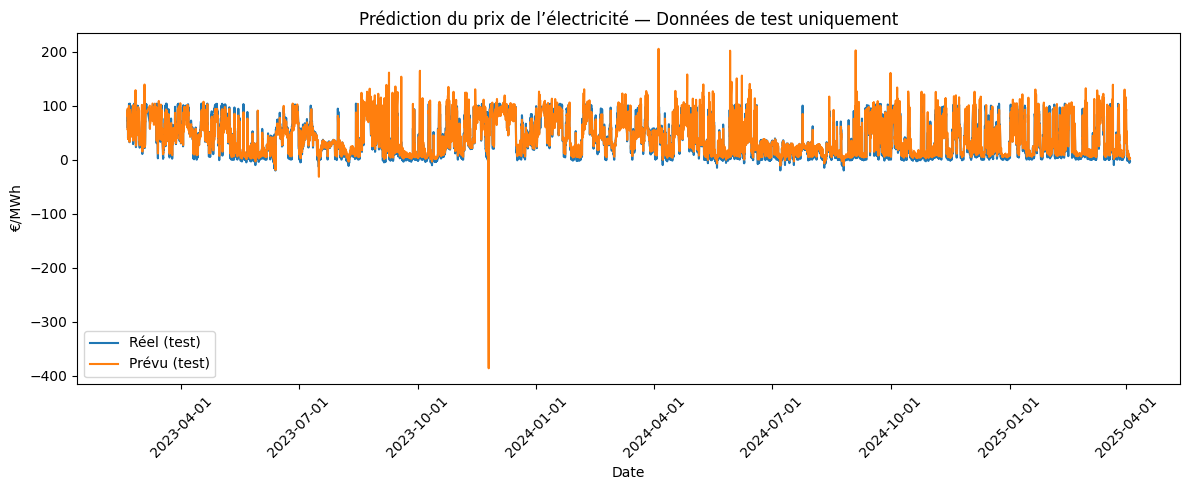

In [137]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

y_test.index = pd.to_datetime(y_test.index)


plt.figure(figsize=(12, 5))

# Affichage des vraies valeurs et des prédictions (test uniquement)
plt.plot(y_test.index, y_test, label="Réel (test)")
plt.plot(y_test.index, y_pred, label="Prévu (test)")

# Mise en forme
plt.legend()
plt.title("Prédiction du prix de l’électricité — Données de test uniquement")
plt.xlabel("Date")
plt.ylabel("€/MWh")

# Rendre les dates lisibles
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


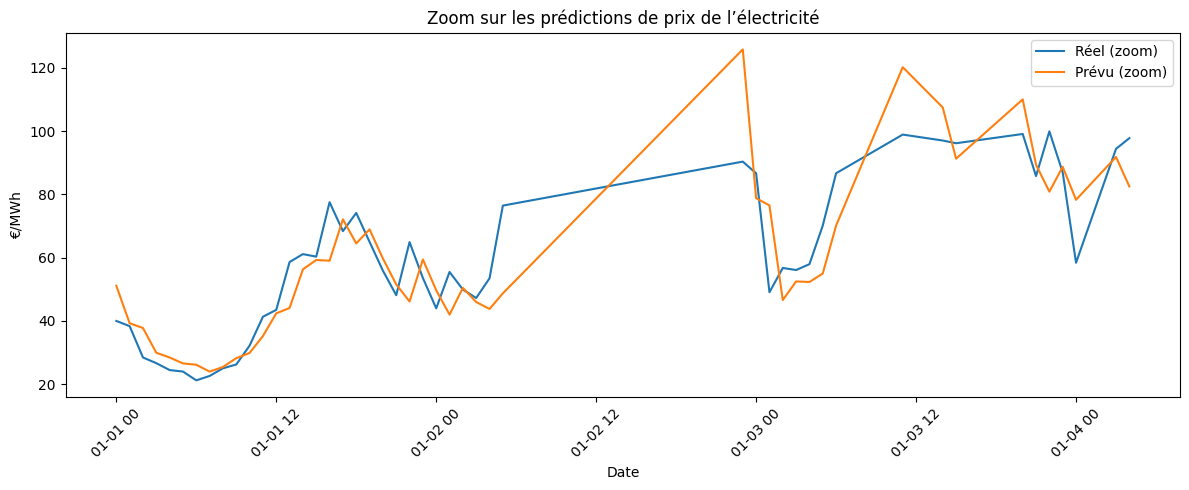

In [139]:
start = "2024-01-01"
end = "2024-01-07"

# Masque pour extraire les dates dans l’intervalle
mask = (y_test.index >= start) & (y_test.index <= end)

plt.figure(figsize=(12, 5))
plt.plot(y_test.loc[mask], label="Réel (zoom)")
plt.plot(y_test.loc[mask].index, y_pred[mask], label="Prévu (zoom)")

plt.legend()
plt.title("Zoom sur les prédictions de prix de l’électricité")
plt.xlabel("Date")
plt.ylabel("€/MWh")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
